# IPWC Bug

@roman_avj
1 Nov 23

Look how to fix the $\hat{G}(t_{n}) == 0$

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis, IPCRidge
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees, GradientBoostingSurvivalAnalysis
from scipy.integrate import simpson

TYPE_INFO = 'ALL_DATA'

# Data

## Preprocessing

In [2]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2_rent.parquet')
df_model.info()

[FATAL] 2023-11-13 00:30:30.650 Aws::Config::ConfigFileProfileFSM [0x2015a2280] Unknown parser error: unexpected state 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 28.5+ MB


In [3]:
# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

### Create Synthetic Variable

In [5]:
# look rows with maximum time2event
df_max = df_model[df_model['time2event'] == df_model['time2event'].max()]
df_max

,id,marketplace,first_observed_date,last_observed_date,count_repeated,time2event,event,id_sepomex,listing_type,property_type,...,bin_group_marketplace,woe_marketplace,bin_group_seller,woe_seller,bin_group_id_sepomex,woe_id_sepomex,diff_first_prediction,sine_tmonth,cosine_tmonth,has_maintenance
1048,49af96c340647cb6d5f75c6f3262932c,inmuebles24,2023-03-26 01:20:13,2023-07-25 04:56:52,2,121.0,1,11629,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_3,1.282975,0.202517,1.000000e+00,6.123234e-17,0
1230,191020db12d230bbe988db301beabbf4,inmuebles24,2023-06-17 01:31:28,2023-10-09 19:48:39,1,121.0,0,11779,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_2,0.175340,-0.441785,1.224647e-16,-1.000000e+00,0
4043,47685c3c48d8cad2f2be1aa15cf657fb,inmuebles24,2023-06-03 05:22:22,2023-10-02 20:03:47,11,121.0,1,11752,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_1,-0.277533,0.117295,1.224647e-16,-1.000000e+00,0
6727,0487e3c66cc2b86292ff89a6bec950d8,inmuebles24,2023-06-17 01:11:40,2023-10-09 19:48:36,2,121.0,0,11143,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_1,-0.277533,-0.026623,1.224647e-16,-1.000000e+00,0
7926,40ac91d12de60e74dd3a12b263e0f9b4,inmuebles24,2023-03-12 02:19:51,2023-07-11 03:05:28,3,121.0,1,12756,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_0,-0.740097,-0.209105,1.000000e+00,6.123234e-17,0
8022,4691ee468b0aa4ece5c2c5e928fcf85e,easybroker,2023-06-17 11:47:39,2023-10-16 18:24:21,2,121.0,0,12687,for-rent,house,...,group_0,-0.397016,group_2,0.065077,group_1,-0.277533,0.034263,1.224647e-16,-1.000000e+00,0
8522,5456808b253e7c1a9ab5ebbb30a8da10,inmuebles24,2023-06-16 19:26:50,2023-10-09 20:09:28,1,121.0,0,12727,for-rent,house,...,group_3,0.235393,group_2,0.065077,group_2,0.175340,0.000872,1.224647e-16,-1.000000e+00,0
8929,9dc42b1319d4d33455fad8c1386da8af,inmuebles24,2023-04-23 00:42:26,2023-08-22 05:40:35,4,121.0,1,11498,for-rent,apartment,...,group_3,0.235393,group_3,1.810651,group_2,0.175340,-0.000946,8.660254e-01,-5.000000e-01,0
11515,5d1cb7c57a7fd60c5106aa7b56feb5d6,metros_cubicos,2023-03-19 05:33:47,2023-07-18 06:09:00,3,121.0,1,11534,for-rent,apartment,...,group_2,0.025046,group_2,0.065077,group_2,0.175340,0.122776,1.000000e+00,6.123234e-17,0
11705,43f8a9bffec7f4ac0700ef4cd3bc6224,metros_cubicos,2023-04-23 06:15:33,2023-08-23 04:57:36,5,121.0,1,11547,for-rent,apartment,...,group_2,0.025046,group_2,0.065077,group_2,0.175340,0.453131,8.660254e-01,-5.000000e-01,0


In [6]:
# get a random id from df_max, first trye for event == 1, then for event == 0
id_max = df_max[df_max['event'] == 1]['id'].sample(1, random_state=8).values[0]
if pd.isna(id_max):
    id_max = df_max[df_max['event'] == 0]['id'].sample(1, random_state=8).values[0]

In [7]:
# look at the data for id_max
df_model[df_model['id'] == id_max][['time2event', 'event']]

,time2event,event
23511,121.0,1


In [8]:
# for id_max add 1 to time2event and set event = 1
df_model.loc[df_model['id'] == id_max, 'time2event'] =\
     df_model.loc[df_model['id'] == id_max, 'time2event'] + 1

df_model.loc[df_model['id'] == id_max, 'event'] = 1

### Selection

In [9]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bathrooms', 'num_parking_lots']
vars_x_woe = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex']
vars_x_numerical = [
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'surface_total', 'page_on_marketplace',
    'is_new_property_prob', 'total_cost_of_living', 'green_index', 'days_active',
    'relative_cost_of_living'
    ]
vars_x_binary = ['is_exterior', 'pets_allowed', 'has_maintenance']
vars_x_geographic = ['latitude', 'longitude']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_woe

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

22
22


### Train & Test

In [10]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       26541 non-null  category
 1   property_type                      26541 non-null  category
 2   first_price                        26541 non-null  float64 
 3   diff_first_prediction              26541 non-null  float64 
 4   prediction_price_per_square_meter  26541 non-null  float64 
 5   surface_total                      26541 non-null  float64 
 6   page_on_marketplace                26541 non-null  float64 
 7   is_new_property_prob               26541 non-null  float64 
 8   total_cost_of_living               26541 non-null  float64 
 9   green_index                        26541 non-null  float64 
 10  days_active                        26541 non-null  float64 
 11  relative_cost_of_living            26541 

In [11]:
# one hot encoding #
data_x_numeric = OneHotEncoder().fit_transform(data_x)
colnames_x_numeric = data_x_numeric.columns

# boxcox (yeo-johnson) transformation BY property type #
def boxcox(X):
    # power_transform
    power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    X_transf = power_transform.transform(X)
    return X_transf, power_transform

# get boxcox transformation for each property type
boxcox_vars_property = [
    'first_price', 'prediction_price_per_square_meter', 'surface_total', 'is_new_property_prob'
]
# difference between vars_x_numerical and boxcox_vars_property
boxcox_vars_all = list(set(vars_x_numerical) - set(boxcox_vars_property))
# box cox transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get boxcox transformation
data_x_numeric.loc[idx_house, boxcox_vars_property], pt_house = boxcox(data_x_numeric.loc[idx_house, boxcox_vars_property])
data_x_numeric.loc[idx_apartment, boxcox_vars_property], pt_apartment = boxcox(data_x_numeric.loc[idx_apartment, boxcox_vars_property])
data_x_numeric[boxcox_vars_all], pt_all = boxcox(data_x_numeric[boxcox_vars_all])

# scale #
# scale
def scale(X):
    # power_transform
    standard_scaler = StandardScaler().fit(X)
    X_transf = standard_scaler.transform(X)
    return X_transf, standard_scaler

# get scaler transformation for each property type
standard_vars = vars_x_discrete
# scaler transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get scaler transformation
data_x_numeric.loc[idx_house, standard_vars], st_house = scale(data_x_numeric.loc[idx_house, standard_vars])
data_x_numeric.loc[idx_apartment, standard_vars], st_apartment = scale(data_x_numeric.loc[idx_apartment, standard_vars])
# to numeric
data_x_numeric = data_x_numeric.to_numpy()


dropped categorical variable 'listing_type', because it has only 1 values


In [12]:
# to numeric
pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).head(3)

,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,green_index,days_active,...,is_exterior,pets_allowed,has_maintenance,num_bathrooms,num_parking_lots,latitude,longitude,woe_marketplace,woe_seller,woe_id_sepomex
0,0.0,-1.449619,-0.747566,-1.290174,-0.613845,-0.348624,-0.544545,-0.572298,-1.048412,-1.296468,...,0.0,1.0,0.0,0.310737,-0.768490,19.478474,-99.210293,0.025046,0.065077,0.17534
1,0.0,-1.586037,-1.030759,-0.932039,-0.964186,-1.038756,-0.158285,1.141924,-1.048412,-1.296468,...,0.0,0.0,0.0,-1.097058,-0.170226,19.478672,-99.206866,0.235393,0.065077,0.17534
2,0.0,-1.847394,-1.738722,-1.486820,-0.578656,0.492888,-0.673979,-0.776076,-1.048412,-1.296468,...,0.0,0.0,0.0,-1.097058,0.128907,19.479462,-99.207931,-0.113731,0.065077,0.17534


#### Get in train the maximum observed time

In [13]:
# get the row with id_max
data_x_max = data_x_numeric[df_model['id'] == id_max]
idx_delete = df_model[df_model['id'] == id_max].index
data_x_max

array([[ 1.00000000e+00, -8.68050287e-01,  8.92679886e-01,
        -5.89516148e-01, -1.32364319e+00, -1.03875636e+00,
        -1.66789942e-02,  9.02466756e-01,  4.88605886e-01,
         8.58983115e-01, -5.19650983e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.55541922e-01,
        -4.53727283e-01,  1.95222140e+01, -9.91476360e+01,
         2.35393029e-01,  6.50769960e-02,  1.75339938e-01]])

In [14]:
# delete row_id_max from data_x_numeric
data_x_numeric = np.delete(data_x_numeric, idx_delete, axis=0)

# also delete from data_y
data_y_max = data_y[idx_delete]
data_y = np.delete(data_y, idx_delete, axis=0)

In [15]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42
)

In [16]:
# add id_max to X_train & y_train
X_train = np.vstack([X_train, data_x_max])
y_train = np.hstack([y_train, data_y_max])

# Modelo V0: avg

## Fit

In [17]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class AvgModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.global_mean = None
        self.group_means = None
    
    def fit(self, X, y):
        # Create a DataFrame from the structured array y
        y_df = pd.DataFrame({'Status': y['Status'], 'Survival_in_days': y['Survival_in_days']})
        
        # Merge X and y 
        merged_data = pd.concat([X, y_df], axis=1)

        # Filter out observations without an event
        merged_data = merged_data[merged_data['Status'] >= 1]
        
        # Group the data by X1, X2, ..., Xp values and compute the average Survival_in_days for each group
        self.group_means = merged_data.groupby(list(X.columns))['Survival_in_days'].mean().reset_index()
        
        # Compute the global average of Survival_in_days
        self.global_mean = y_df.query("Status >= 1")['Survival_in_days'].mean()
    
    def predict(self, X):
        # Merge the test data (X) with the group means on X1, X2, ..., Xp values
        merged_data = X.merge(self.group_means, on=list(X.columns), how='left')
        
        # Fill missing group means with the global mean
        merged_data['Survival_in_days'].fillna(self.global_mean, inplace=True)
        
        return merged_data['Survival_in_days'].values

In [18]:
# get x data
df_x = df_model.copy()[['listing_type', 'property_type', 'id_sepomex_raw', 'event']]
y_val = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# split train & test
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    df_x, y_val, test_size=0.2, random_state=42
)

In [19]:
# train 
basemode = AvgModel()
basemode.fit(X_train_base, y_train_base)

## Train

In [20]:
def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict
# predict mean time
Xobs, yobs = get_observed(X_train_base, y_train_base)
mean_time = basemode.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 26.122
MAPE: 0.943


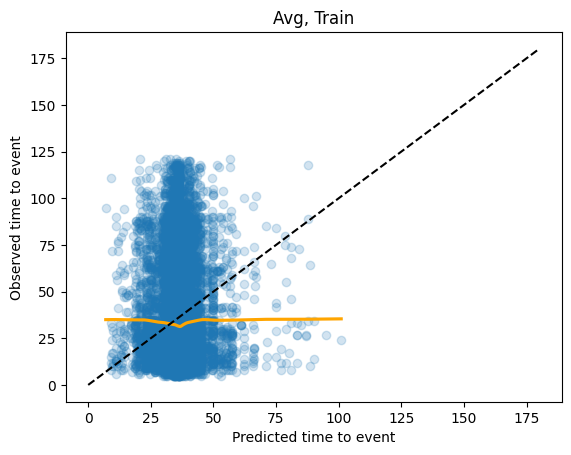

In [21]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('Avg, Train')
plt.show()

## Test

### General

In [22]:
# predict
# predict mean time
Xobs, yobs = get_observed(X_test_base, y_test_base)
mean_time = basemode.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 26.318
MAPE: 0.925


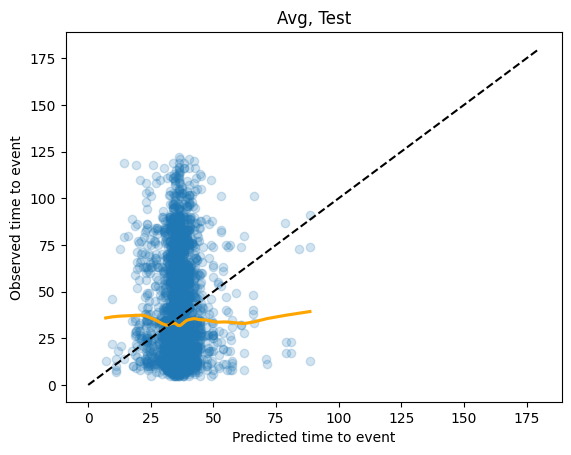

In [23]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('Avg, Test')
plt.show()

### Particular

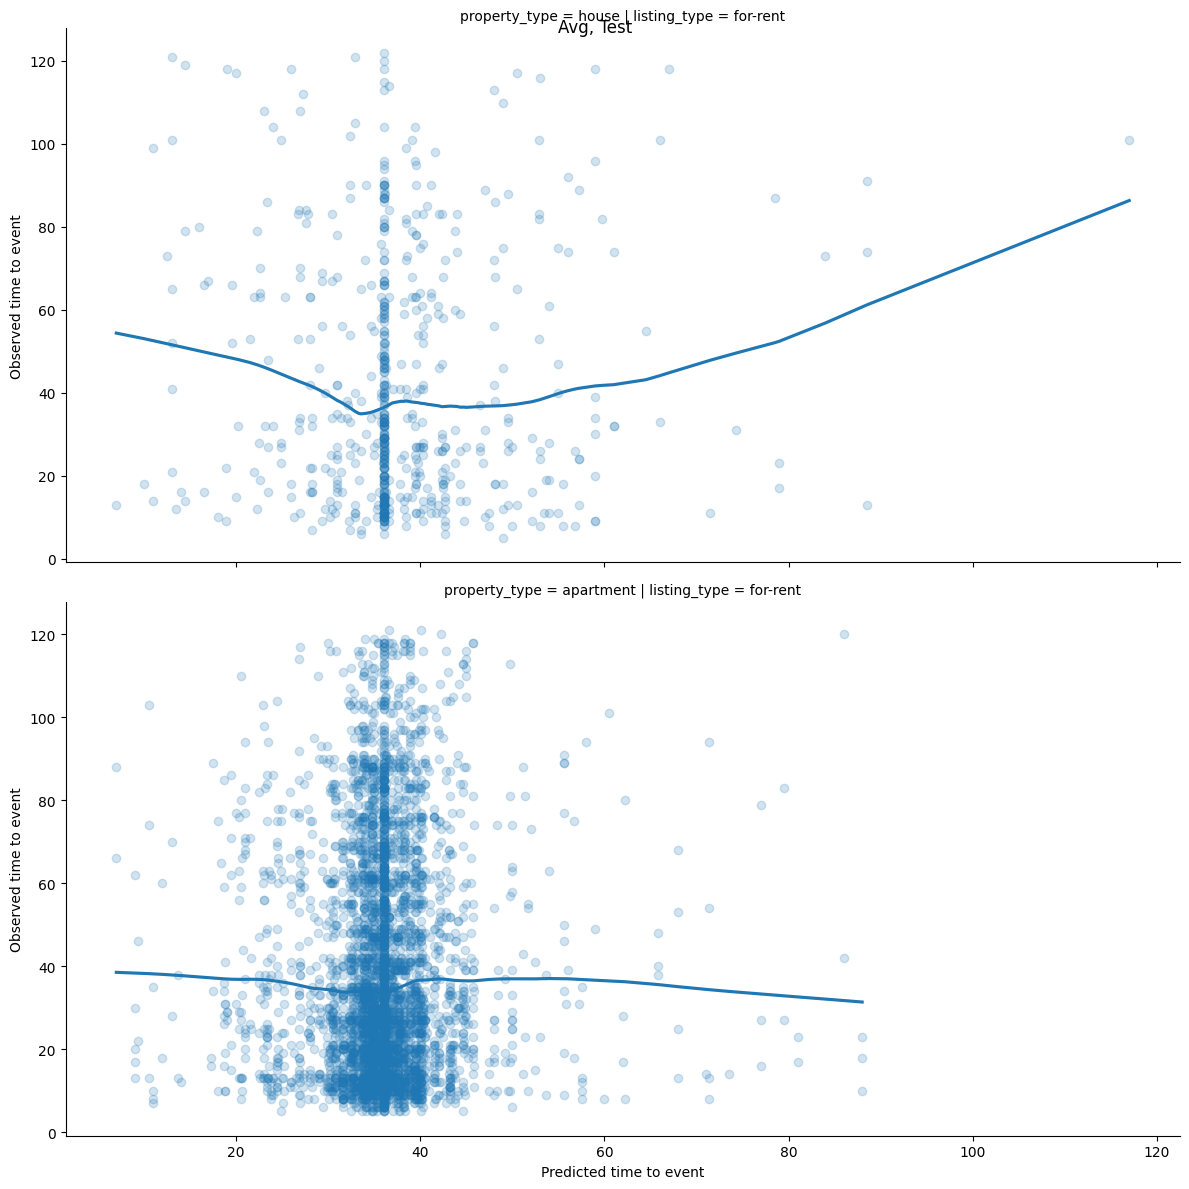

In [24]:
# get df of predictions and observed
df_pred = (
    X_test_base.copy()
    .assign(
        predicted_time=basemode.predict(X_test_base),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test_base['Survival_in_days'],
        event=y_test_base['Status']
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, col='listing_type', row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('Avg, Test')
plt.show()

In [25]:
# get rmse and mape by listing_type and property_type
def get_metrics(df):
    df = df.copy()
    cindex = concordance_index_censored(df['event'], df['observed_time'], df['risk_score'])[0]
    # rmse & mape for all with event as True
    rmse = np.sqrt(np.mean((df[df['event']]['predicted_time'] - df[df['event']]['observed_time'])**2))
    mape = np.mean(np.abs((df[df['event']]['predicted_time'] - df[df['event']]['observed_time']) / df[df['event']]['observed_time']))
    return pd.Series({'rmse': rmse, 'mape': mape, 'cindex': cindex})

# get all
table_pred = (
    df_pred
    .groupby(['listing_type', 'property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
os.makedirs('../../results/vanillas/', exist_ok=True)
table_pred.to_csv('../../results/vanillas/avg_all_data.csv', index=True)
table_pred
    

rmse      mape    cindex type_info
listing_type property_type                                         
for-rent     apartment      25.853914  0.918054  0.518398  ALL_DATA
             house          29.538071  0.977921  0.481273  ALL_DATA

# COX PH

## Fit

In [26]:
# train cox
coxph_all = CoxPHSurvivalAnalysis()
coxph_all.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [27]:
# look params
pd.Series(coxph_all.coef_, index=colnames_x_numeric).sort_values()

first_price                         -0.218689
property_type=house                 -0.173560
total_cost_of_living                -0.067134
page_on_marketplace                 -0.066879
days_active                         -0.049305
diff_first_prediction               -0.046476
num_parking_lots                    -0.033612
has_maintenance                     -0.015052
is_new_property_prob                 0.020483
num_bathrooms                        0.025671
green_index                          0.028985
is_exterior                          0.033013
pets_allowed                         0.044605
relative_cost_of_living              0.044653
prediction_price_per_square_meter    0.071781
surface_total                        0.083068
latitude                             0.111046
woe_seller                           0.205654
woe_id_sepomex                       0.242985
longitude                            0.270031
woe_marketplace                      0.526677
dtype: float64

## Train

In [28]:
# concordance index
cindex_train = concordance_index_censored(y_train['Status'], y_train['Survival_in_days'], coxph_all.predict(X_train))
print('C-index train: {:.3f}'.format(cindex_train[0]))

C-index train: 0.591


In [29]:
# time to eval
va_times = np.linspace(5, 120, 5)

# get integrated brier score
cph_surv_prob = np.row_stack([fn(va_times) for fn in coxph_all.predict_survival_function(X_train)])

# brier score
ibs = integrated_brier_score(y_train, y_train, cph_surv_prob, va_times)
print('IBS: {:.3f}'.format(ibs))

IBS: 0.352


In [30]:
def get_mean_time(X, model, t0=0, tn=100):
    """Get mean time to event for a given time interval."""
    delta = np.linspace(t0, tn, 1000)
    surv_probas = np.row_stack([fn(delta) for fn in model.predict_survival_function(X)])

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])
    return(mean_time)

def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict mean time
Xobs, yobs = get_observed(X_train, y_train)
mean_time = get_mean_time(Xobs, coxph_all, t0=0, tn=120)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 44.212
MAPE: 1.000


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


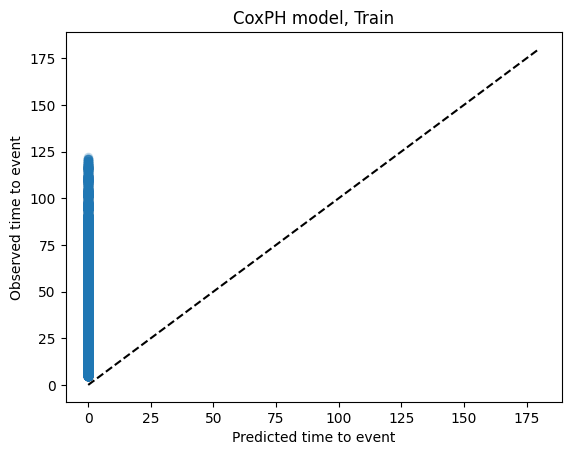

In [31]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('CoxPH model, Train')
plt.show()

## Test

In [32]:
# concordance index
cindex_test = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], coxph_all.predict(X_test))
print('C-index test: {:.3f}'.format(cindex_test[0]))

C-index test: 0.594


In [33]:
# get integrated brier score
cph_surv_prob = np.row_stack([fn(va_times) for fn in coxph_all.predict_survival_function(X_test)])

# brier score
ibs = integrated_brier_score(y_train, y_test, cph_surv_prob, va_times)
print('IBS: {:.3f}'.format(ibs))

IBS: 0.359


In [34]:
def get_mean_time(X, model, t0=0, tn=100):
    """Get mean time to event for a given time interval."""
    delta = np.linspace(t0, tn, 1000)
    surv_probas = np.row_stack([fn(delta) for fn in model.predict_survival_function(X)])

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])
    return(mean_time)

def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict mean time
Xobs, yobs = get_observed(X_test, y_test)
mean_time = get_mean_time(Xobs, coxph_all, t0=0, tn=120)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 45.220
MAPE: 1.000


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


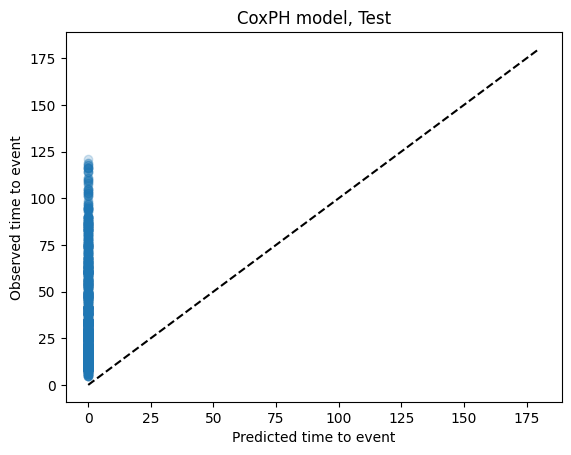

In [35]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('CoxPH model, Test')
plt.show()

### Particular

/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


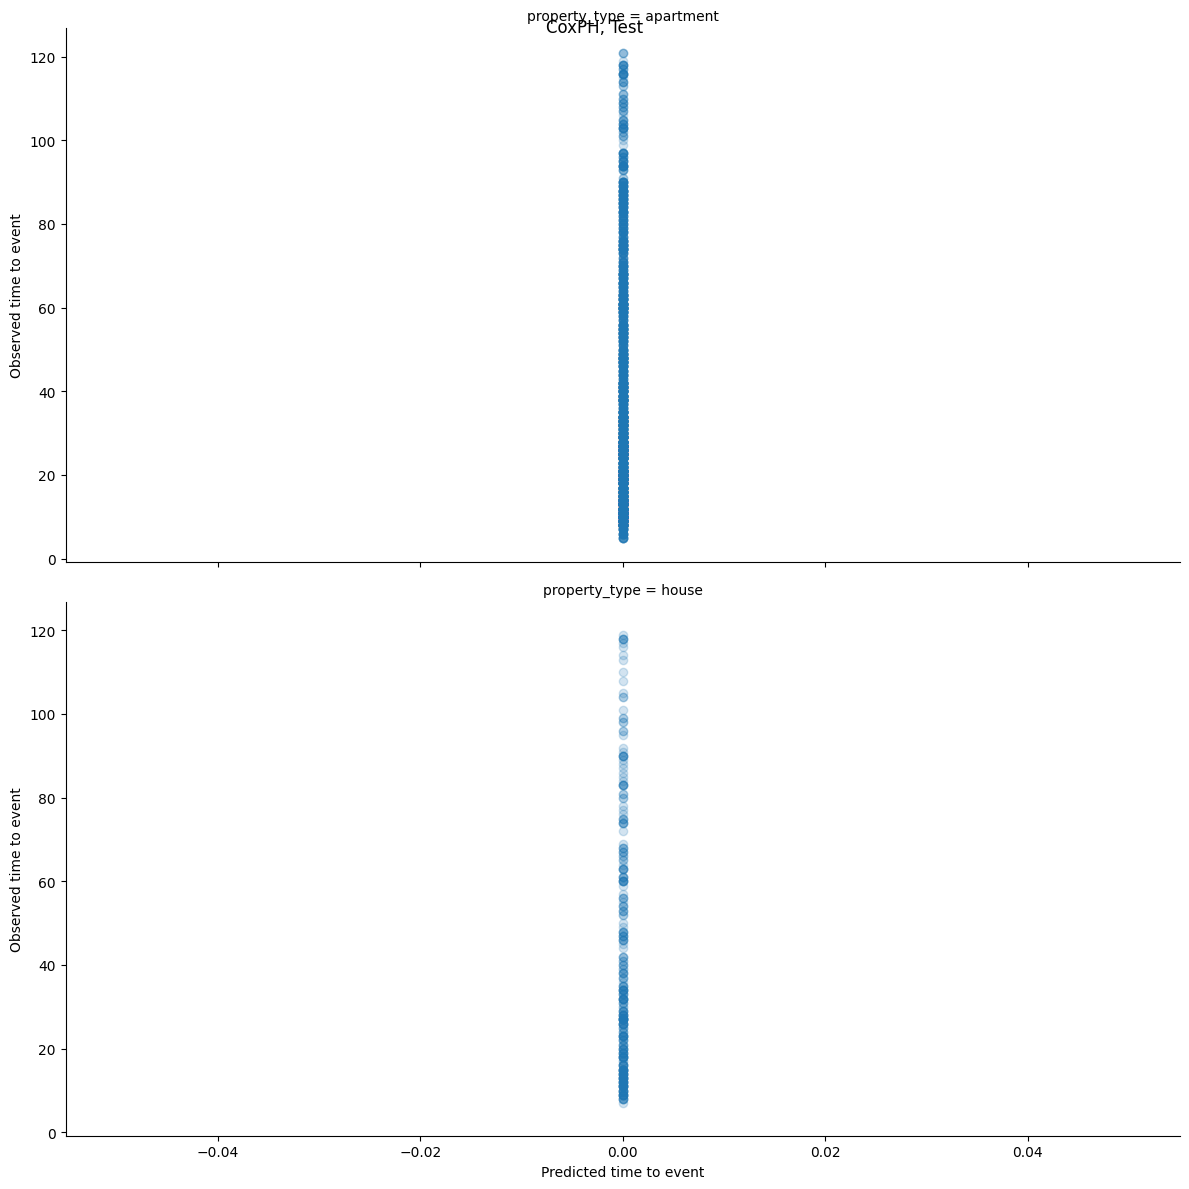

In [36]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=get_mean_time(X_test, coxph_all, t0=0, tn=10),
        risk_score=coxph_all.predict(X_test),
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'listing_type=for-sale': 'listing_type',
        'property_type=house': 'property_type',
    })
    .assign(
        # listing_type=lambda x: np.where(x['listing_type'] == 1, 'for-sale', 'for-rent'),
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('CoxPH, Test')
plt.show()

In [37]:
# get metrics
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/coxph_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,44.758050,1.0,0.590176,ALL_DATA
house,48.517463,1.0,0.617753,ALL_DATA


# IPCRidge

## Fit

In [38]:
aft_fit = IPCRidge(alpha=0.5)
aft_fit.fit(X_train, y_train)

IPCRidge(alpha=0.5)

In [39]:
# look params
pd.Series(aft_fit.coef_, index=colnames_x_numeric).sort_values()

woe_marketplace                     -0.213025
prediction_price_per_square_meter   -0.136423
surface_total                       -0.102291
latitude                            -0.101335
green_index                         -0.057628
woe_seller                          -0.032769
relative_cost_of_living             -0.026052
woe_id_sepomex                      -0.016145
has_maintenance                     -0.003817
is_new_property_prob                 0.000082
num_bathrooms                        0.013026
num_parking_lots                     0.015109
pets_allowed                         0.039780
days_active                          0.054433
diff_first_prediction                0.060039
first_price                          0.134904
total_cost_of_living                 0.152863
is_exterior                          0.168189
page_on_marketplace                  0.183024
property_type=house                  0.223277
longitude                            0.303969
dtype: float64

## Train

In [40]:
# r2
aft_fit.score(X_train, y_train)

0.5590407453034801

In [41]:
# get mape & mse
Xobs, yobs = get_observed(X_train, y_train)
mean_time = aft_fit.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 25.069
MAPE: 0.931


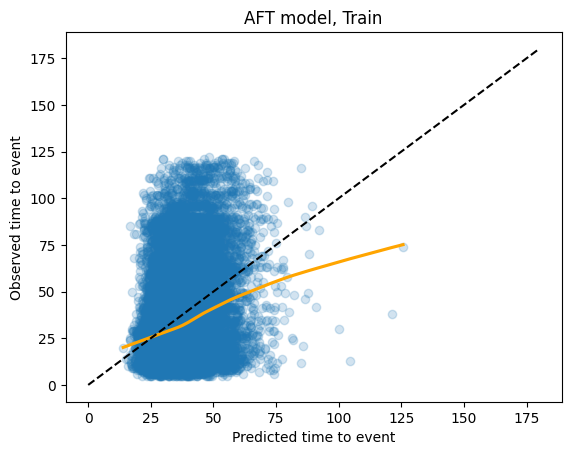

In [42]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('AFT model, Train')
plt.show()

## Test

In [43]:
# r2
aft_fit.score(X_test, y_test)

0.5615568834960314

In [44]:
# get mape & mse
Xobs, yobs = get_observed(X_test, y_test)
mean_time = aft_fit.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 25.143
MAPE: 0.884


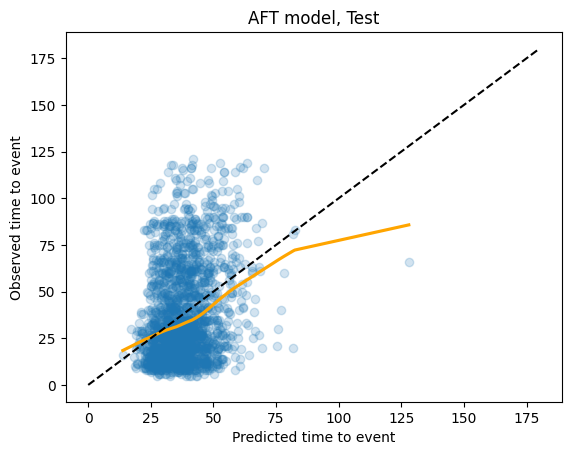

In [45]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('AFT model, Test')
plt.show()

### Particular

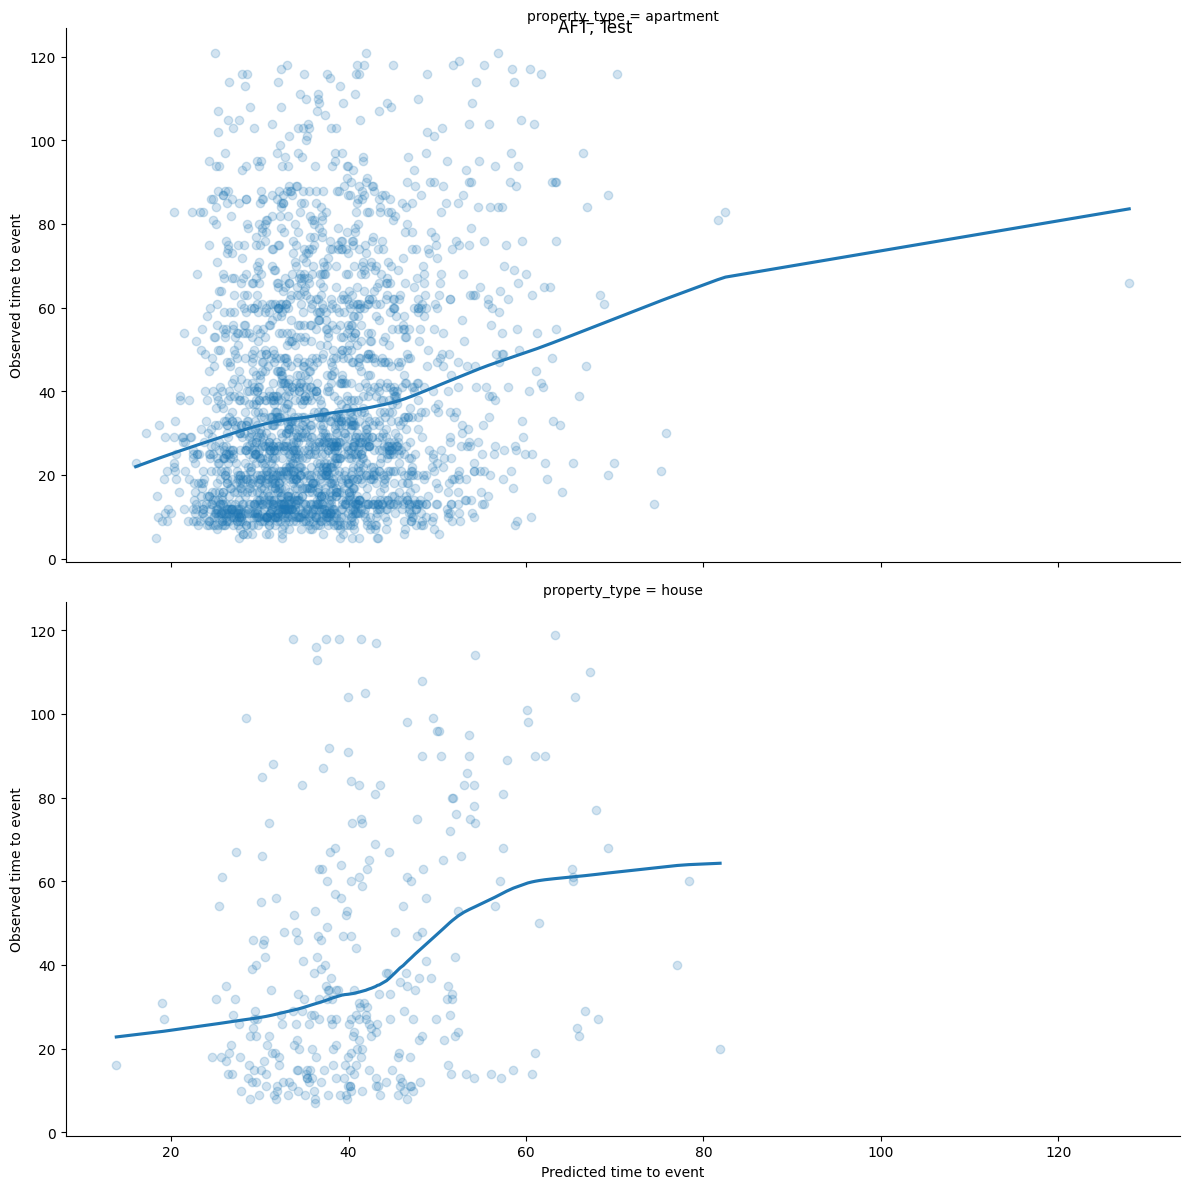

In [46]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=aft_fit.predict(X_test),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('AFT, Test')
plt.show()

In [47]:
# get all
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/aft_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,24.991080,0.879299,0.554359,ALL_DATA
house,26.243484,0.916720,0.614422,ALL_DATA


# Gradient Boosting

## Fit

In [48]:
gbst_ipcw = GradientBoostingSurvivalAnalysis(
    loss='ipcwls',
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42
)
gbst_ipcw.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(loss='ipcwls', n_estimators=1000,
                                 random_state=42)

## Train

In [49]:
# get mape & mse
Xobs, yobs = get_observed(X_train, y_train)
mean_time = gbst_ipcw.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 22.980
MAPE: 0.593


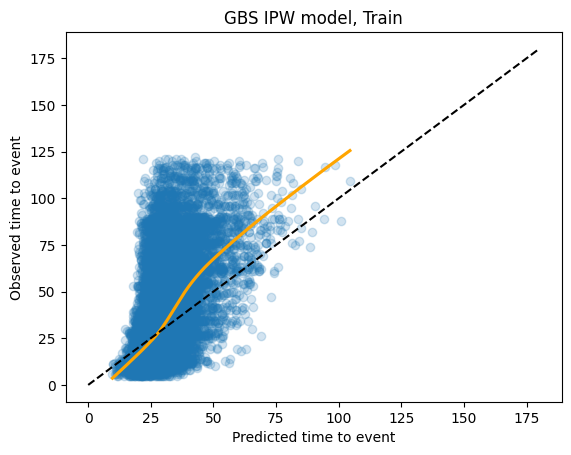

In [50]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GBS IPW model, Train')
plt.show()

### Test

In [51]:
# get mape & mse
Xobs, yobs = get_observed(X_test, y_test)
mean_time = gbst_ipcw.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 25.896
MAPE: 0.668


In [52]:
# get r2 
gbst_ipcw.score(X_test, y_test)

0.5915940607608795

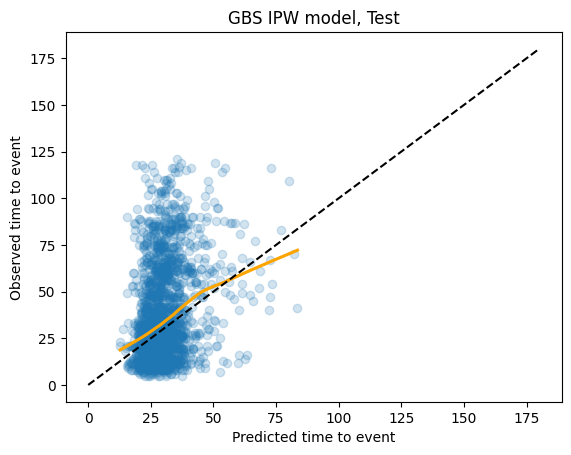

In [53]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GBS IPW model, Test')
plt.show()

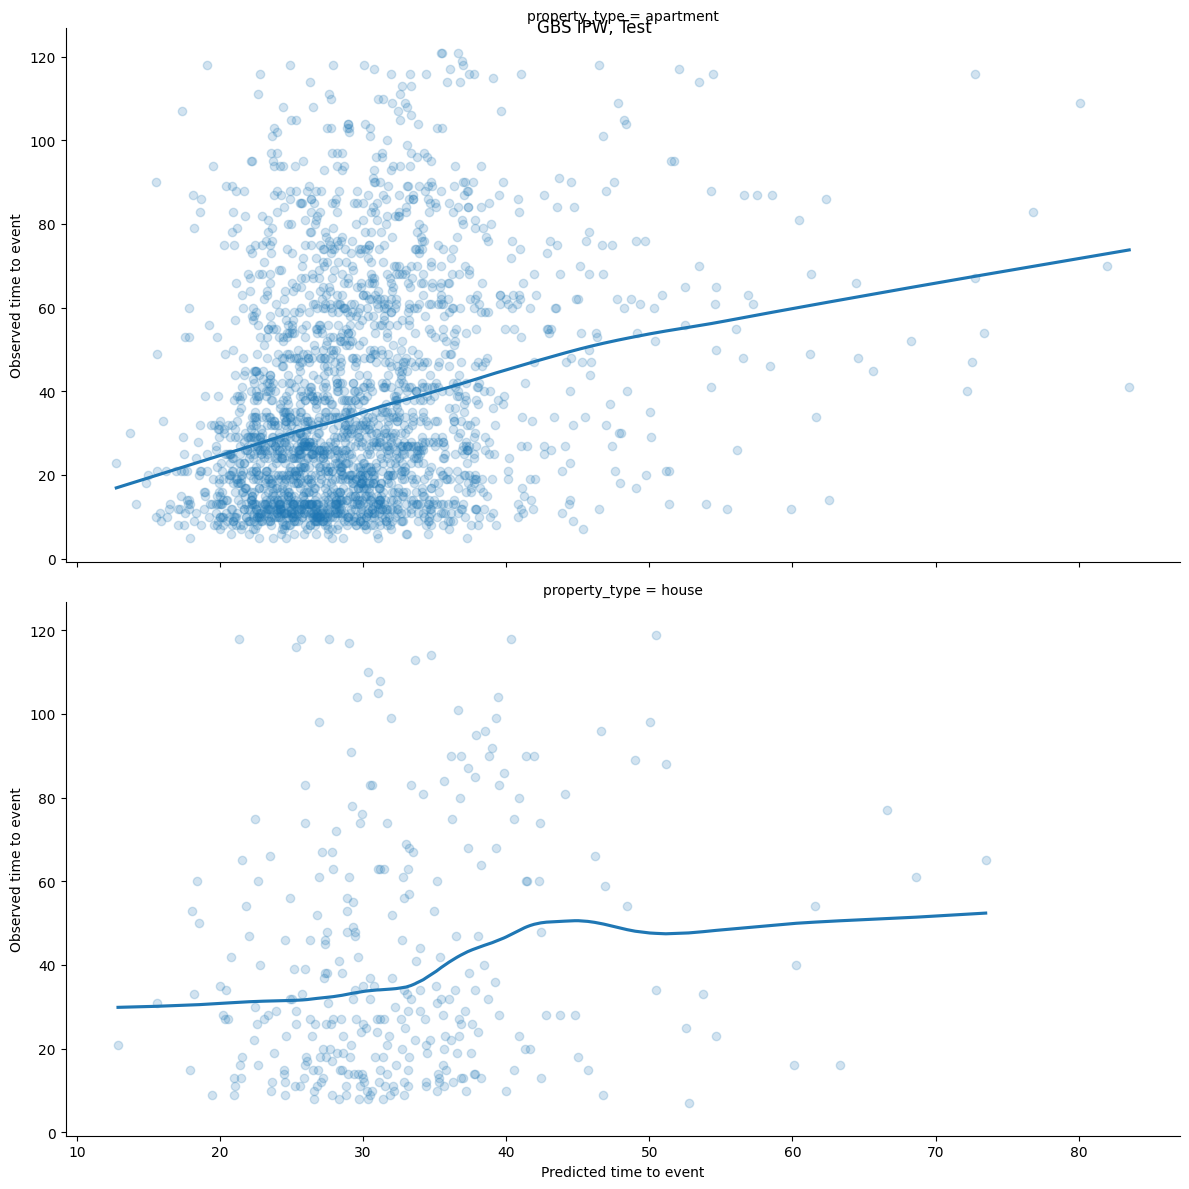

In [54]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=gbst_ipcw.predict(X_test),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GBS IPW, Test')
plt.show()

In [55]:
# get all
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/gbs_ipw_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,25.520579,0.658080,0.595743,ALL_DATA
house,28.528686,0.740605,0.563216,ALL_DATA


# XGBSE: Debaised BCE

## Fit

In [56]:
from xgbse import XGBSEDebiasedBCE

In [57]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [58]:
xgb_debiased = XGBSEDebiasedBCE()
xgb_debiased.fit(
    X=X_train_bis, 
    y=y_train_bis, 
    validation_data=(X_val, y_val), 
    early_stopping_rounds=10, 
    verbose_eval=50,
    time_bins=np.arange(1, 120, 1)
    )

[0]	validation-aft-nloglik:11.61460
[50]	validation-aft-nloglik:3.66333
[100]	validation-aft-nloglik:3.59864
[142]	validation-aft-nloglik:3.59760


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 500},
                 xgb_params={'aft_loss_distribution': 'normal',
                             'aft_loss_distribution_scale': 1,
                             'booster': 'dart', 'colsample_bynode': 0.5,
                             'eval_metric': 'aft-nloglik',
                             'learning_rate': 0.05, 'max_depth': 8,
                             'min_child_weight': 50,
                             'objective': 'survival:aft', 'subsample': 0.5,
                             'tree_method': 'hist'})

## Train

In [59]:
# see predictions
Xobs, yobs = get_observed(X_train, y_train)

# predict
df_mean_km = xgb_debiased.predict(Xobs)

RMSE: 26.011
MAPE: 1.171


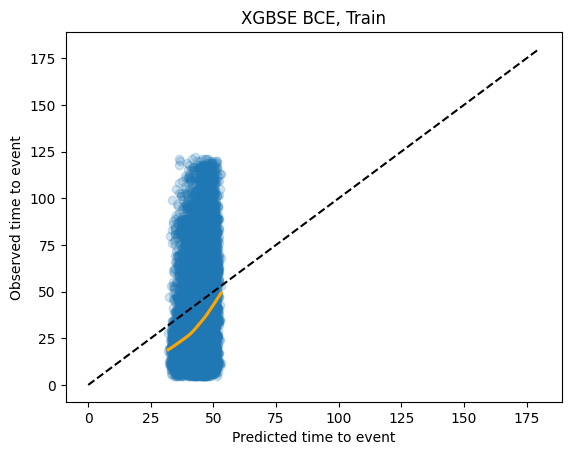

In [60]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE BCE, Train')
plt.show()

## Test

RMSE: 26.198
MAPE: 1.122


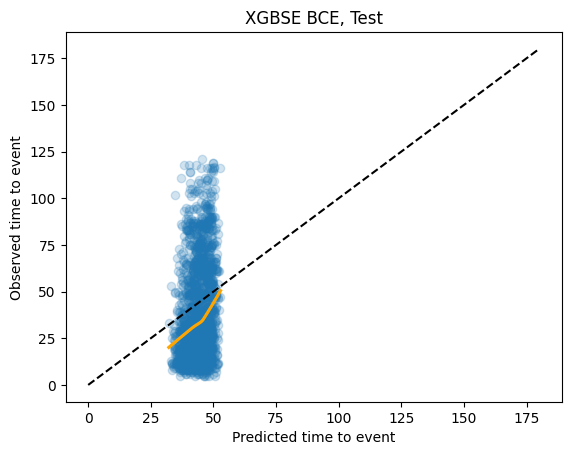

In [61]:
# see predictions
Xobs, yobs = get_observed(X_test, y_test)

# predict
df_mean_km = xgb_debiased.predict(Xobs)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE BCE, Test')
plt.show()

### Particularm

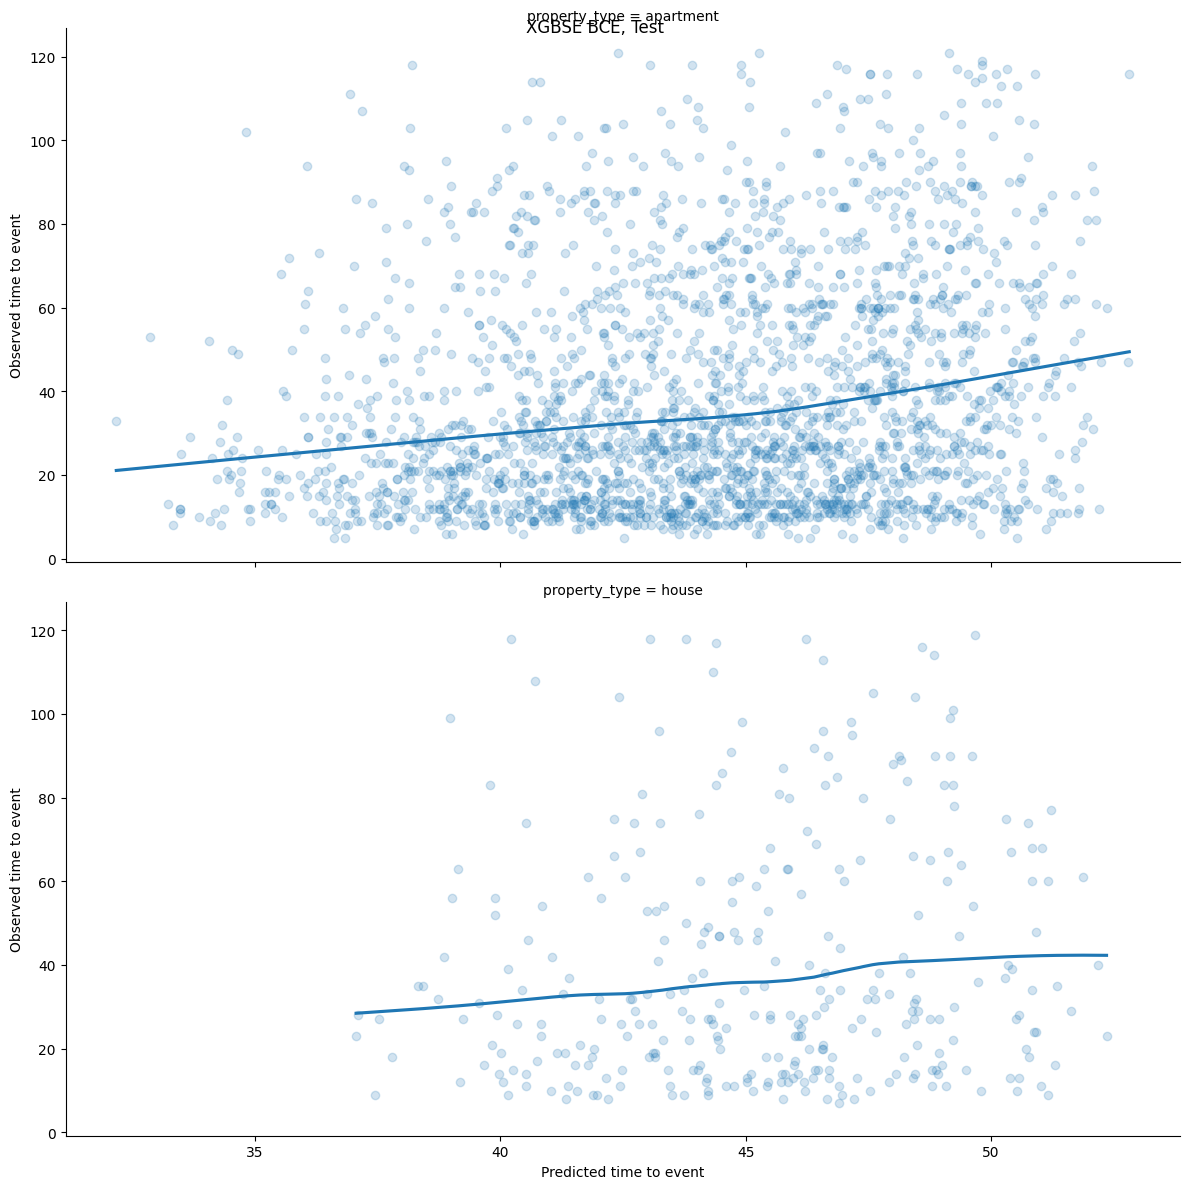

In [62]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=xgb_debiased.predict(X_test).pipe(get_xgbse_mean_time),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('XGBSE BCE, Test')
plt.show()

In [63]:
# get all
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/xgbse_bce_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,25.859424,1.120924,0.599045,ALL_DATA
house,28.585914,1.133047,0.570053,ALL_DATA


# XGBSE: Weibull

## Fit

In [64]:
from xgbse import XGBSEStackedWeibull


In [65]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [66]:
xgb_weibull = XGBSEStackedWeibull()
xgb_weibull.fit(
    X=X_train_bis, 
    y=y_train_bis, 
    validation_data=(X_val, y_val), 
    early_stopping_rounds=10, 
    verbose_eval=50,
    time_bins=np.arange(1, 171, 1)
    )

[0]	validation-aft-nloglik:11.61460


[50]	validation-aft-nloglik:3.66333
[100]	validation-aft-nloglik:3.59864
[143]	validation-aft-nloglik:3.59752


XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})

## Train

In [67]:
# see predictions
Xobs, yobs = get_observed(X_train, y_train)

# predict
df_mean_km = xgb_weibull.predict(Xobs)

In [68]:
df_mean_km

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,170.0
0,0.994821,0.985217,0.972791,0.958182,0.941794,0.923928,0.904824,0.884685,0.863685,0.841977,...,0.000008,0.000007,0.000006,0.000006,0.000005,0.000005,0.000004,0.000004,0.000003,0.000003
1,0.997770,0.993274,0.987192,0.979805,0.971290,0.961780,0.951382,0.940186,0.928269,0.915701,...,0.000594,0.000551,0.000512,0.000475,0.000441,0.000409,0.000380,0.000352,0.000326,0.000303
2,0.999512,0.998386,0.996751,0.994666,0.992168,0.989285,0.986040,0.982450,0.978534,0.974306,...,0.042393,0.040976,0.039601,0.038266,0.036971,0.035714,0.034494,0.033311,0.032164,0.031051
3,0.996489,0.989714,0.980761,0.970067,0.957912,0.944500,0.929999,0.914549,0.898270,0.881272,...,0.000073,0.000067,0.000061,0.000055,0.000050,0.000046,0.000042,0.000038,0.000035,0.000031
4,0.999073,0.997047,0.994191,0.990618,0.986402,0.981598,0.976251,0.970397,0.964068,0.957294,...,0.010525,0.010037,0.009571,0.009124,0.008696,0.008287,0.007896,0.007521,0.007163,0.006821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17961,0.996546,0.989872,0.981044,0.970492,0.958491,0.945245,0.930916,0.915642,0.899544,0.882726,...,0.000079,0.000073,0.000066,0.000060,0.000055,0.000050,0.000046,0.000042,0.000038,0.000034
17962,0.994590,0.984604,0.971716,0.956590,0.939651,0.921210,0.901519,0.880788,0.859197,0.836907,...,0.000006,0.000005,0.000005,0.000004,0.000004,0.000003,0.000003,0.000003,0.000002,0.000002
17963,0.999025,0.996904,0.993919,0.990192,0.985800,0.980801,0.975242,0.969160,0.962591,0.955565,...,0.009226,0.008788,0.008369,0.007968,0.007585,0.007219,0.006869,0.006535,0.006216,0.005912
17964,0.997193,0.991658,0.984257,0.975341,0.965135,0.953804,0.941482,0.928282,0.914302,0.899629,...,0.000218,0.000201,0.000185,0.000170,0.000157,0.000144,0.000132,0.000122,0.000112,0.000103


RMSE: 26.389
MAPE: 0.983


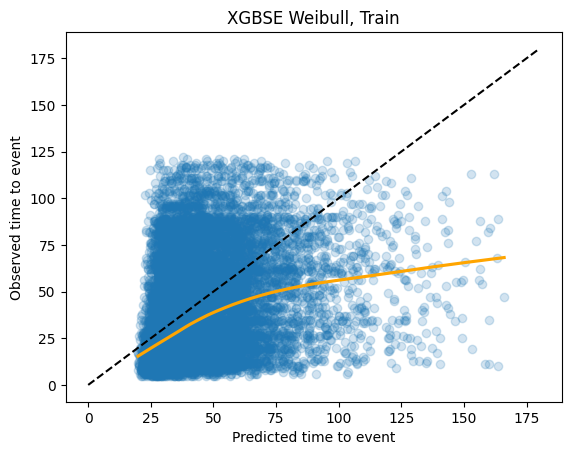

In [69]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE Weibull, Train')
plt.show()

## Test

RMSE: 28.868
MAPE: 1.052


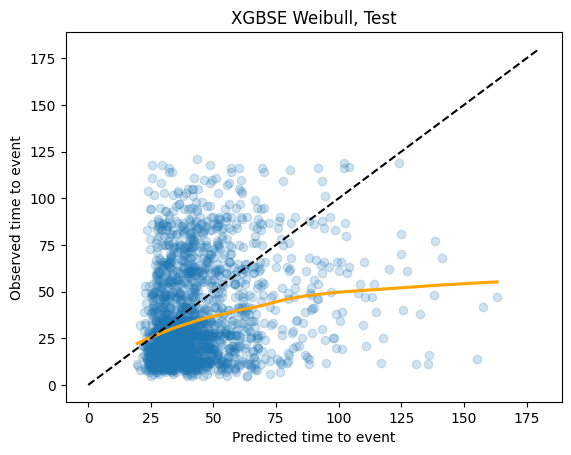

In [70]:
# see predictions
Xobs, yobs = get_observed(X_test, y_test)

# predict
df_mean_km = xgb_weibull.predict(Xobs)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE Weibull, Test')
plt.show()

### Particular

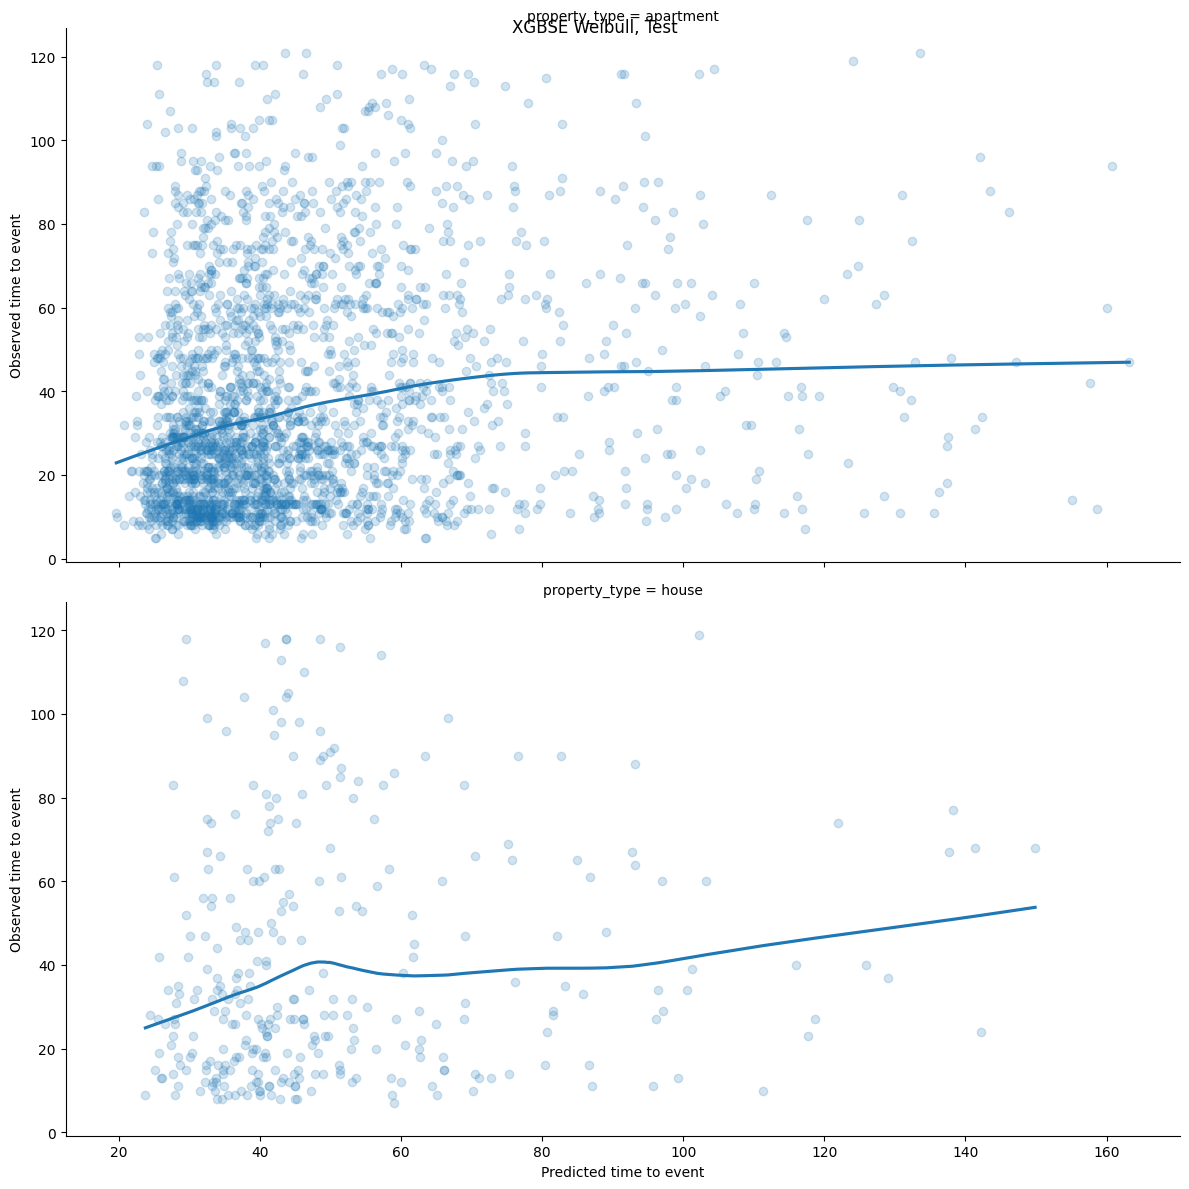

In [71]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=xgb_weibull.predict(X_test).pipe(get_xgbse_mean_time),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred,row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('XGBSE Weibull, Test')
plt.show()

In [72]:
# get all
table_pred = (
    df_pred
    .groupby([ 'property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/xgbse_weibull_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,28.457440,1.041413,0.609294,ALL_DATA
house,31.753931,1.127295,0.595941,ALL_DATA


# Naive Approach: Dont Use Censorship

## Fit

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000, 
    learning_rate=0.1,
    random_state=42
)
X_train_obs = X_train[y_train['Status']]
y_train_obs = y_train[y_train['Status']]['Survival_in_days']
gbr.fit(X_train_obs, y_train_obs)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

## Train

In [74]:
# concordance index
cindex_train = concordance_index_censored(y_train['Status'], y_train['Survival_in_days'], - gbr.predict(X_train))
print('C-index train: {:.3f}'.format(cindex_train[0]))

C-index train: 0.670


In [75]:
# get mape & mse
Xobs, yobs = get_observed(X_train, y_train)
mean_time = gbr.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time[:10] - yobs[:10])**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time[:10] - yobs[:10]) / yobs[:10]))
print('MAPE: {:.3f}'.format(mape))

RMSE: 9.603
MAPE: 0.385


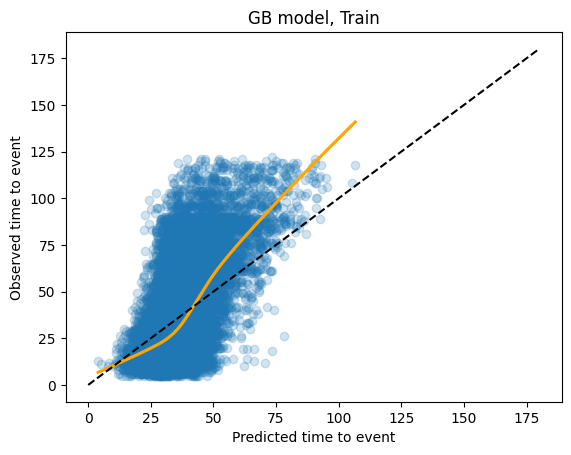

In [76]:
### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GB model, Train')
plt.show()

## Test

In [78]:
# concordance index
cindex_test = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], - gbr.predict(X_test))
print('C-index test: {:.3f}'.format(cindex_test[0]))

C-index test: 0.577


RMSE: 24.828
MAPE: 0.828


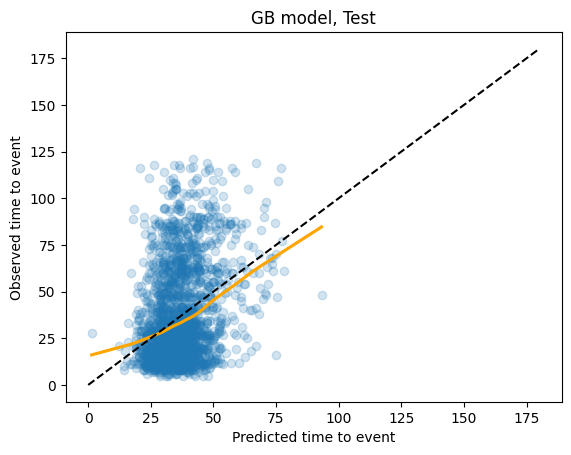

In [79]:
# get mape & mse
Xobs, yobs = get_observed(X_test, y_test)
mean_time = gbr.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GB model, Test')
plt.show()

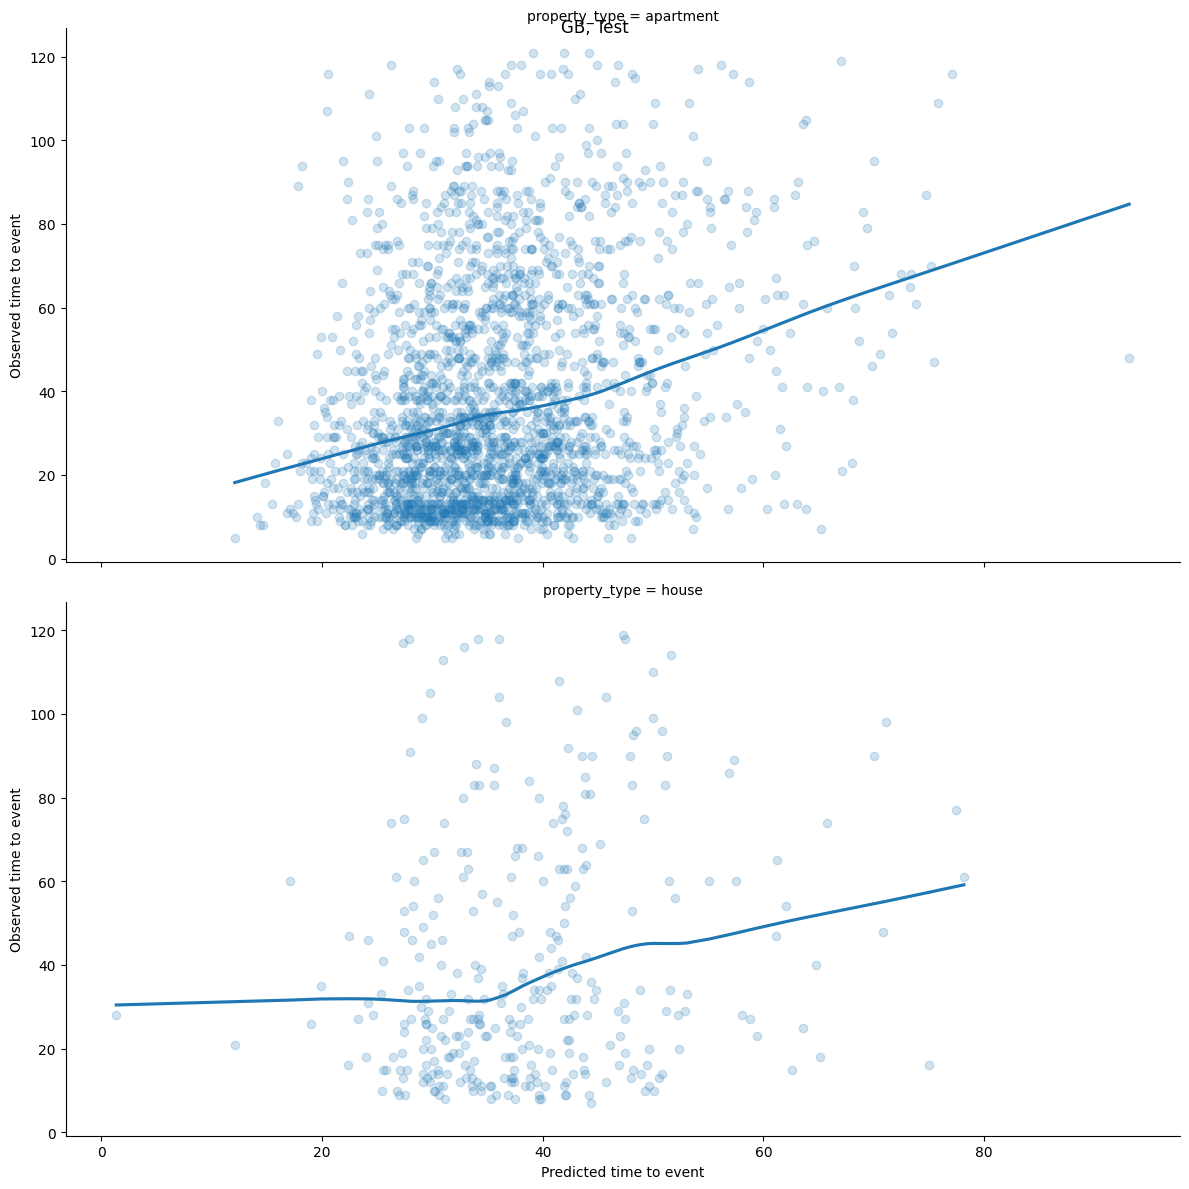

In [80]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=gbr.predict(X_test),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GB, Test')
plt.show()

In [81]:
# get all
table_pred = (
    df_pred
    .groupby([ 'property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/gb_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,24.485038,0.820536,0.577994,ALL_DATA
house,27.242388,0.880129,0.570256,ALL_DATA
